# Определение перспективного тарифа для телеком-компании

В нашем распоряжении данные компании «Мегалайн» — федерального оператора сотовой связи. Клиенты используют только два тарифных плана: «Смарт» и «Ультра». Наша цель понять, какой тариф приносит больше денег.

Предоставлены данные выборки из 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод, какой тариф лучше.

Главная цель проекта - определить, какой тариф более прибыльный для оператора, отличаются ли ежемесячные траты пользователей двух тарифов.

Идти к этой цели мы будем в несколько шагов:
1. Посмотрим на предоставленную базу данных (5 таблиц), очистим данные и подготовим к анализу
2. Создадим единую базу анализа, в которой будут храниться данные по 500 пользователям помесячно (каждый пользователь - до 12 строк итоговой таблицы).
3. Проанализируем каждую переменную отдельно.
4. Проверим основные гипотезы о различных тратах пользователей в разных тарифах, а также в Москве и в регионах.
5. Сделаем общий вывод.

В проекте используются библиотеки pandas, numpy, matplotlib. Анализ взаимосвязей проводится на основе коэффициентов корреляции, проверка статистических гипотез на основе t-тестов и построения распределений переменных на графиках.

## Предварительное изучение и подготовка данных из выгрузок

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

Читаем файл. Заранее оговорим, что с первого раза не получится, т.к. в базе особый разделитель в данных - ",", укажем его в качестве аргумента. Десятые доли отображаются корректно, поэтому аргумент decimals при чтении данных опустим.

### Выгрузка звонков

Первая база данных звонков содержит id пользователя и звонка, а также дату и длительность звонка.

In [2]:
df_calls = pd.read_csv('calls.csv', sep= ',')
display(df_calls)
df_calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Пропусков нет. Первая переменная - id, заведена как текст. Она состоит из id пользователя и порядкового номера звонка. На данном этапе нет необходимости выделять отдельно порядковый номер звонка.

А вот в переменной даты звонка нам понадобится день недели, месяц и год. Выделим их в отдельные переменные.

In [3]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])
df_calls['weekday'] = df_calls['call_date'].dt.weekday
df_calls['month'] = df_calls['call_date'].dt.month
df_calls['year'] = df_calls['call_date'].dt.year
display(df_calls)
df_calls.info()

,id,call_date,duration,user_id,weekday,month,year
0,1000_0,2018-07-25,0.00,1000,2,7,2018
1,1000_1,2018-08-17,0.00,1000,4,8,2018
2,1000_2,2018-06-11,2.85,1000,0,6,2018
3,1000_3,2018-09-21,13.80,1000,4,9,2018
4,1000_4,2018-12-15,5.18,1000,5,12,2018
...,...,...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,2,12,2018
202603,1499_216,2018-10-18,18.83,1499,3,10,2018
202604,1499_217,2018-11-10,10.81,1499,5,11,2018
202605,1499_218,2018-10-06,4.27,1499,5,10,2018


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
 4   weekday    202607 non-null  int64         
 5   month      202607 non-null  int64         
 6   year       202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 10.8+ MB


Полученные переменные созданы корректно, ошибок нет. Посмотрим на вторую переменную - длительность звонков.

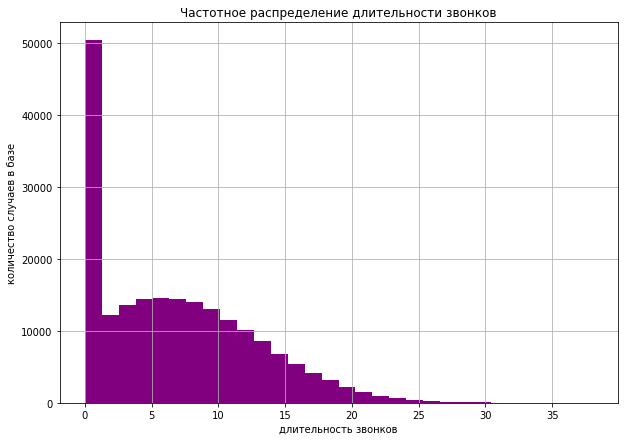

In [4]:
df_calls['duration'].hist(bins=30,color='purple',figsize=(10,7))
plt.title('Частотное распределение длительности звонков')
plt.xlabel('длительность звонков')
plt.ylabel('количество случаев в базе')
plt.show()

В документах к заданию указано, что 0 - это "недозвоны". Т.к. у нас данные тольк об исходящих звонках, то 0 - это ситуация, когда пользователь набрал номер, а адресат не взял трубку. Количество таких ситуаций - четверть. Похоже на правду. Таким образом, ошибок в данной базе не найдено.

Однако у нас есть примечание - звонки тарифицируются поминутно. Т.к. мы исследуем траты по тарифам, а не действительную длительность разговоров, округлим количество звонков до целых в большую сторону, как это делает оператор, и переведём эти значения в целые числа.

In [5]:
df_calls['duration'] = np.ceil(df_calls['duration'])
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
 4   weekday    202607 non-null  int64         
 5   month      202607 non-null  int64         
 6   year       202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 10.8+ MB


В дальнейшем мы будем работать с данными по каждому пользователю помесячно. Создадим новую таблицу, которую будем в дальнейшем соединять в единую базу по пользователям помесячно.

In [6]:
df_calls_monthly = pd.pivot_table(df_calls, index=['user_id','month'], values='duration', aggfunc={'sum'})
df_calls_monthly

sum
user_id month       
1000    5      159.0
        6      172.0
        7      340.0
        8      408.0
        9      466.0
...              ...
1498    10     247.0
1499    9       70.0
        10     449.0
        11     612.0
        12     492.0

[3174 rows x 1 columns]

### Выгрузка по интернет-трафику

Здесь у нас id сессии, созданный по тому же принципу, что и в базе звонков, объём использованных мегабайт и дата выхода в интернет.

In [7]:
df_internet = pd.read_csv('internet.csv', sep= ',')
display(df_internet)
df_internet.info()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Пропусков нет. Разделим переменную даты сессии на три переменные - год, месяц и день недели.

In [8]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])
df_internet['weekday'] = df_internet['session_date'].dt.weekday
df_internet['month'] = df_internet['session_date'].dt.month
df_internet['year'] = df_internet['session_date'].dt.year
display(df_internet)
df_internet.info()

,Unnamed: 0,id,mb_used,session_date,user_id,weekday,month,year
0,0,1000_0,112.95,2018-11-25,1000,6,11,2018
1,1,1000_1,1052.81,2018-09-07,1000,4,9,2018
2,2,1000_2,1197.26,2018-06-25,1000,0,6,2018
3,3,1000_3,550.27,2018-08-22,1000,2,8,2018
4,4,1000_4,302.56,2018-09-24,1000,0,9,2018
...,...,...,...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499,2,10,2018
149392,149392,1499_153,490.13,2018-12-14,1499,4,12,2018
149393,149393,1499_154,0.00,2018-10-27,1499,5,10,2018
149394,149394,1499_155,1246.32,2018-11-26,1499,0,11,2018


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
 5   weekday       149396 non-null  int64         
 6   month         149396 non-null  int64         
 7   year          149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 9.1+ MB


Переменные сформированы корректно.

Посмотрим на переменную размера израсходованного трафика за сессию.

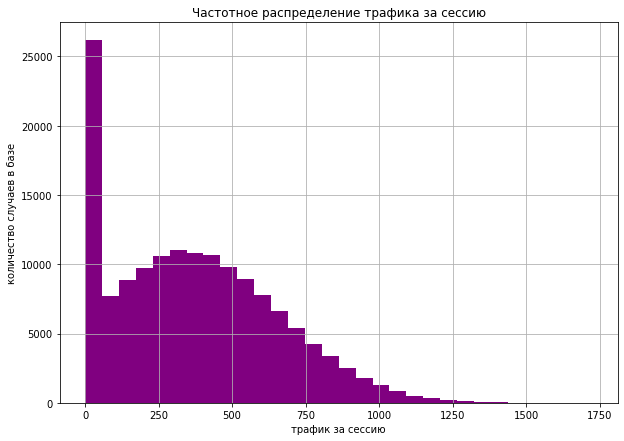

In [9]:
df_internet['mb_used'].hist(bins=30,color='purple',figsize=(10,7))
plt.title('Частотное распределение трафика за сессию')
plt.xlabel('трафик за сессию')
plt.ylabel('количество случаев в базе')
plt.show()

Посмотрим на значения, близкие к нулю, ближе:

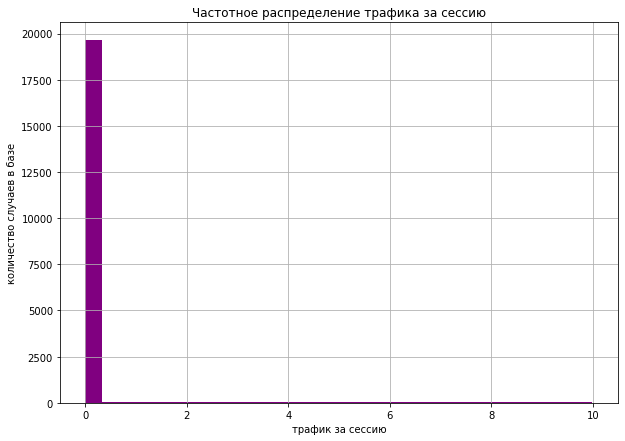

In [10]:
df_internet.query("mb_used < 10")['mb_used'].hist(bins=30,color='purple',figsize=(10,7))
plt.title('Частотное распределение трафика за сессию')
plt.xlabel('трафик за сессию')
plt.ylabel('количество случаев в базе')
plt.show()

У нас 13% случаев в базе по интернет-трафику имеют значение ровно 0Мб. Возможно, это нетарифицируемый трафик, на который операторы иногда формируют спецпредложения для пользователей. Мы не знаем природу этих данных, поэтому удалять их или заменять не будем. Для подсчёта среднего в будущем будем иметь ввиду, что при работе с данной переменной стоит фильтровать значения больше 0.

Исследуемый оператор тарифицирует интернет-трафик, округляя до гигабайт, но делает это только с суммарным трафиком за месяц. Создадим новую базу с месячным трафиком в гигабайтах и id пользователя. Присвоим каждому пользователю в данной базе его трафик за данный месяц, округлённый до гигабайт, как это делает оператор.

In [11]:
df_internet_monthly = pd.pivot_table(df_internet, index=['user_id','month'], values='mb_used', aggfunc={'sum'})
df_internet_monthly['sum'] = (df_internet_monthly['sum']/1024).apply(np.ceil).astype(int)
df_internet_monthly

sum
user_id month     
1000    5        3
        6       23
        7       14
        8       14
        9       15
...            ...
1498    10      21
1499    9        2
        10      18
        11      18
        12      13

[3203 rows x 1 columns]

### Выгрузка по сообщениям

In [12]:
df_messages = pd.read_csv('messages.csv', sep= ',')
display(df_messages)
df_messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Пропусков нет. Аналогично разделим переменную даты на день недели, месяц и год:

In [13]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])
df_messages['weekday'] = df_messages['message_date'].dt.weekday
df_messages['month'] = df_messages['message_date'].dt.month
df_messages['year'] = df_messages['message_date'].dt.year
display(df_messages)
df_messages.info()

,id,message_date,user_id,weekday,month,year
0,1000_0,2018-06-27,1000,2,6,2018
1,1000_1,2018-10-08,1000,0,10,2018
2,1000_2,2018-08-04,1000,5,8,2018
3,1000_3,2018-06-16,1000,5,6,2018
4,1000_4,2018-12-05,1000,2,12,2018
...,...,...,...,...,...,...
123031,1499_179,2018-12-12,1499,2,12,2018
123032,1499_180,2018-09-28,1499,4,9,2018
123033,1499_181,2018-09-27,1499,3,9,2018
123034,1499_182,2018-11-15,1499,3,11,2018


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
 3   weekday       123036 non-null  int64         
 4   month         123036 non-null  int64         
 5   year          123036 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 5.6+ MB


Подготовим таблицу по сообщениям для дальнейшего аггрегирования:

In [14]:
df_messages_monthly = pd.pivot_table(df_messages, index=['user_id','month'], values='id', aggfunc={'count'})
df_messages_monthly

count
user_id month       
1000    5         22
        6         60
        7         75
        8         81
        9         57
...              ...
1498    10        42
1499    9         11
        10        48
        11        59
        12        66

[2717 rows x 1 columns]

### Таблица с тарифами

In [15]:
df_tariffs = pd.read_csv('tariffs.csv', sep= ',')
display(df_tariffs)
df_tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Для расчёта трат помесячно нам предоставлена информация о стоимости ежемесячных лимитов, а также о тарификации дополнительных трат.

### Данные о пользователях

Также нам предоставлена база данных о пользователях. В данном случае нам понадобятся их id, город проживания, возраст и тариф. Читаем файл:

In [16]:
df_users = pd.read_csv('users.csv', sep= ',')
display(df_users)
df_users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Проверим важные нам переменные на пропуски и неверные значения:

In [17]:
df_users['age'].describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

Возраст варьируется в базе от 18 до 75 лет, среднее приближено к медиане, распределение возраста схоже с нормальным.

Посмотрим на варианты городов и тарифов:

In [18]:
df_users['city'].value_counts()

Москва             99
Санкт-Петербург    39
Новосибирск        16
Омск               14
Казань             14
                   ..
Архангельск         1
Иваново             1
Нижневартовск       1
Химки               1
Подольск            1
Name: city, Length: 76, dtype: int64

Пользователей по каждому городу немного, вряд ли удастся сравнить практики пользования тарифами в разных городах, однако нам нужно будет сравнить данные среди москвичей и жителей регионов. Создадим соответствующую переменную:

In [19]:
def city_group(row):

    city = row['city']

    if city == 'Москва':
        return 1
                    
    return 0 

df_users['city_grouped'] = df_users.apply(city_group, axis=1)
df_users.loc[:,['city_grouped','city']].sample(10)

,city_grouped,city
322,0,Балашиха
105,0,Улан-Удэ
147,0,Якутск
291,1,Москва
331,1,Москва
26,0,Мурманск
189,0,Санкт-Петербург
59,0,Курск
66,0,Астрахань
487,0,Кострома


Пременная создана корректно. Каждый пятый пользователь - из Москвы.

Посмотрим, всё ли корректно с переменной тарифа, заодно проверив, нет ли зависимости пользования тарифами от проживания в столице.

In [20]:
print(df_users['tariff'].value_counts())
pd.crosstab(
    df_users['city_grouped'], df_users['tariff'],
    values=df_users['tariff'],
    aggfunc='count',
    normalize='columns').applymap(lambda x: "{0:.0f}%".format(100*x))

smart    351
ultra    149
Name: tariff, dtype: int64


tariff,smart,ultra
city_grouped,,
0,81%,79%
1,19%,21%


Москвичей 20% как во всей базе, так и среди пользователей каждого тарифа, что делает данную подвыборку сравнимой с группой жителей регионов.

### Вывод

Мы посмотрели на предоставленные базы данных. Создали промежуточные таблицы с пользованием услуг помесячно (звонки, интернет-трафик, сообщения). При дальнейшей работе необходимо учитывать, что есть существенная доля нулевых по длительности звонков и нулевых сессий трафика. Приступим к работе с агрегированной базой.

## Создание общей агрегированной базы

Соединим созданные ранее промежуточные базы.

In [21]:
df = df_calls_monthly.merge(df_internet_monthly, left_on=['user_id','month'], right_on=['user_id','month'], how='outer')
df = df.merge(df_messages_monthly, left_on=['user_id','month'], right_on=['user_id','month'], how='outer')
df = df.reset_index()
df = df.merge(df_users, left_on='user_id', right_on='user_id', how='outer')

df.columns = (['user_id',
               'month',
               'calls',
               'internet',
               'messages',
               'age',
               'churn_date',
               'city',
               'first_name',
               'last_name',
               'reg_date',
               'tariff',
               'city_grouped'])
df

,user_id,month,calls,internet,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,city_grouped
0,1000,5.0,159.0,3.0,22.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0
1,1000,6.0,172.0,23.0,60.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0
2,1000,7.0,340.0,14.0,75.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0
3,1000,8.0,408.0,14.0,81.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0
4,1000,9.0,466.0,15.0,57.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,NaN,20.0,21.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,0
3212,1489,11.0,NaN,18.0,20.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,0
3213,1489,12.0,NaN,17.0,35.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,0
3214,1128,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,0


В объединённой базе появились пропуски. Пропущенные данные в звонках, интренте-трафике или сообщениях можно считать отсутствующими по причине неиспользования данной услуги, и их можно заполнить нулями. А пропуски в переменной месяца указывают на то, что пользователь подключился и сразу же отключился от тарифа, как в случае с последними двумя кейсами в таблице. Эти строки удалим, а прочие заполним нулями.

In [22]:
df = df.dropna(subset=['month']).copy()
df['calls'] = df['calls'].fillna(0)
df['internet'] = df['internet'].fillna(0)
df['messages'] = df['messages'].fillna(0)
df

,user_id,month,calls,internet,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,city_grouped
0,1000,5.0,159.0,3.0,22.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0
1,1000,6.0,172.0,23.0,60.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0
2,1000,7.0,340.0,14.0,75.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0
3,1000,8.0,408.0,14.0,81.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0
4,1000,9.0,466.0,15.0,57.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8.0,0.0,11.0,17.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,0
3210,1489,9.0,0.0,17.0,32.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,0
3211,1489,10.0,0.0,20.0,21.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,0
3212,1489,11.0,0.0,18.0,20.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,0


Больше нам не нужны колонки с датой регистрации пользователя, именем и фамилией, городом и датой окончания пользования тарифом. Удалим их.

In [23]:
df = df.drop(['churn_date', 'city', 'first_name', 'last_name', 'reg_date'], axis = 1)

В итоговой базе не хватает основной информации - суммы в рублях для каждого кейса (user/month). Для этого нужно воспользоваться информацией из таблицы с тарифами и рассчитать траты каждого пользователя по месяцам.

Добавим информацию о тарифе в нашу базу в каждую строку:

In [24]:
df = df.merge(df_tariffs, left_on='tariff', right_on='tariff_name', how='outer')
df.sample(15)

,user_id,month,calls,internet,messages,age,tariff,city_grouped,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
1329,1071,3.0,283.0,16.0,15.0,20,smart,0,50,15360,500,550,200,3,3,smart
1893,1193,3.0,612.0,12.0,8.0,55,smart,0,50,15360,500,550,200,3,3,smart
2151,1250,12.0,446.0,12.0,43.0,20,smart,0,50,15360,500,550,200,3,3,smart
2623,1372,6.0,448.0,10.0,34.0,71,smart,0,50,15360,500,550,200,3,3,smart
810,1416,8.0,822.0,21.0,84.0,50,ultra,0,1000,30720,3000,1950,150,1,1,ultra
149,1090,11.0,596.0,22.0,28.0,54,ultra,0,1000,30720,3000,1950,150,1,1,ultra
66,1048,12.0,688.0,8.0,78.0,73,ultra,0,1000,30720,3000,1950,150,1,1,ultra
1523,1118,7.0,839.0,15.0,0.0,65,smart,0,50,15360,500,550,200,3,3,smart
333,1201,10.0,723.0,9.0,0.0,32,ultra,1,1000,30720,3000,1950,150,1,1,ultra
724,1382,6.0,681.0,8.0,74.0,42,ultra,0,1000,30720,3000,1950,150,1,1,ultra


В случайно выбранных 15 строках столбцы по тарифам совпадают. Обработаем полученную базу:
1. Удалим "лишний" столбец с тарифом,
2. Пересчитаем расход интернет-трафика в гигабайты,
3. Переименуем столбцы, чтобы таблица занимала меньше места по горизонтали визуально.

In [25]:
df = df.drop(['tariff_name'], axis = 1)
df['mb_per_month_included'] = df['mb_per_month_included'] / 1024
df.columns = (['user_id',
               'month',
               'calls',
               'gb',
               'sms',
               'age',
               'tariff',
               'city_grouped',
               'sms_limit',
               'gb_limit',
               'mins_limit',
               'rub_monthly_fee',
               'rub_per_gb',
               'rub_per_sms',
               'rub_per_min'])
df

,user_id,month,calls,gb,sms,age,tariff,city_grouped,sms_limit,gb_limit,mins_limit,rub_monthly_fee,rub_per_gb,rub_per_sms,rub_per_min
0,1000,5.0,159.0,3.0,22.0,52,ultra,0,1000,30.0,3000,1950,150,1,1
1,1000,6.0,172.0,23.0,60.0,52,ultra,0,1000,30.0,3000,1950,150,1,1
2,1000,7.0,340.0,14.0,75.0,52,ultra,0,1000,30.0,3000,1950,150,1,1
3,1000,8.0,408.0,14.0,81.0,52,ultra,0,1000,30.0,3000,1950,150,1,1
4,1000,9.0,466.0,15.0,57.0,52,ultra,0,1000,30.0,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8.0,0.0,11.0,17.0,35,smart,0,50,15.0,500,550,200,3,3
3210,1489,9.0,0.0,17.0,32.0,35,smart,0,50,15.0,500,550,200,3,3
3211,1489,10.0,0.0,20.0,21.0,35,smart,0,50,15.0,500,550,200,3,3
3212,1489,11.0,0.0,18.0,20.0,35,smart,0,50,15.0,500,550,200,3,3


Создадим новый столбец в таблице со счётом за месяц в каждой строке. Сначала положим в него только абонентскую плату.

In [26]:
df['bill'] = df['rub_monthly_fee']
df

,user_id,month,calls,gb,sms,age,tariff,city_grouped,sms_limit,gb_limit,mins_limit,rub_monthly_fee,rub_per_gb,rub_per_sms,rub_per_min,bill
0,1000,5.0,159.0,3.0,22.0,52,ultra,0,1000,30.0,3000,1950,150,1,1,1950
1,1000,6.0,172.0,23.0,60.0,52,ultra,0,1000,30.0,3000,1950,150,1,1,1950
2,1000,7.0,340.0,14.0,75.0,52,ultra,0,1000,30.0,3000,1950,150,1,1,1950
3,1000,8.0,408.0,14.0,81.0,52,ultra,0,1000,30.0,3000,1950,150,1,1,1950
4,1000,9.0,466.0,15.0,57.0,52,ultra,0,1000,30.0,3000,1950,150,1,1,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8.0,0.0,11.0,17.0,35,smart,0,50,15.0,500,550,200,3,3,550
3210,1489,9.0,0.0,17.0,32.0,35,smart,0,50,15.0,500,550,200,3,3,550
3211,1489,10.0,0.0,20.0,21.0,35,smart,0,50,15.0,500,550,200,3,3,550
3212,1489,11.0,0.0,18.0,20.0,35,smart,0,50,15.0,500,550,200,3,3,550


Теперь создадим переменные остатков от предоставленного пакета sms, минут и гигабайт. Отрицательные значения перекодируем в 0.

In [27]:
df['sms_left'] = (df['sms'] - df['sms_limit']).clip(lower=0)
df['gb_left'] = (df['gb'] - df['gb_limit']).clip(lower=0)
df['mins_left'] = (df['calls'] - df['mins_limit']).clip(lower=0)

df

,user_id,month,calls,gb,sms,age,tariff,city_grouped,sms_limit,gb_limit,mins_limit,rub_monthly_fee,rub_per_gb,rub_per_sms,rub_per_min,bill,sms_left,gb_left,mins_left
0,1000,5.0,159.0,3.0,22.0,52,ultra,0,1000,30.0,3000,1950,150,1,1,1950,0.0,0.0,0.0
1,1000,6.0,172.0,23.0,60.0,52,ultra,0,1000,30.0,3000,1950,150,1,1,1950,0.0,0.0,0.0
2,1000,7.0,340.0,14.0,75.0,52,ultra,0,1000,30.0,3000,1950,150,1,1,1950,0.0,0.0,0.0
3,1000,8.0,408.0,14.0,81.0,52,ultra,0,1000,30.0,3000,1950,150,1,1,1950,0.0,0.0,0.0
4,1000,9.0,466.0,15.0,57.0,52,ultra,0,1000,30.0,3000,1950,150,1,1,1950,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8.0,0.0,11.0,17.0,35,smart,0,50,15.0,500,550,200,3,3,550,0.0,0.0,0.0
3210,1489,9.0,0.0,17.0,32.0,35,smart,0,50,15.0,500,550,200,3,3,550,0.0,2.0,0.0
3211,1489,10.0,0.0,20.0,21.0,35,smart,0,50,15.0,500,550,200,3,3,550,0.0,5.0,0.0
3212,1489,11.0,0.0,18.0,20.0,35,smart,0,50,15.0,500,550,200,3,3,550,0.0,3.0,0.0


Умножим остаток минут, гигабайт и смс на их стоимость по тарифу и прибавим к абонентской плате.

In [28]:
df['bill'] = (df['sms_left'] * df['rub_per_sms'] +
              df['gb_left'] * df['rub_per_gb'] + 
              df['mins_left'] * df['rub_per_min'] +
              df['bill'])
df

,user_id,month,calls,gb,sms,age,tariff,city_grouped,sms_limit,gb_limit,mins_limit,rub_monthly_fee,rub_per_gb,rub_per_sms,rub_per_min,bill,sms_left,gb_left,mins_left
0,1000,5.0,159.0,3.0,22.0,52,ultra,0,1000,30.0,3000,1950,150,1,1,1950.0,0.0,0.0,0.0
1,1000,6.0,172.0,23.0,60.0,52,ultra,0,1000,30.0,3000,1950,150,1,1,1950.0,0.0,0.0,0.0
2,1000,7.0,340.0,14.0,75.0,52,ultra,0,1000,30.0,3000,1950,150,1,1,1950.0,0.0,0.0,0.0
3,1000,8.0,408.0,14.0,81.0,52,ultra,0,1000,30.0,3000,1950,150,1,1,1950.0,0.0,0.0,0.0
4,1000,9.0,466.0,15.0,57.0,52,ultra,0,1000,30.0,3000,1950,150,1,1,1950.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8.0,0.0,11.0,17.0,35,smart,0,50,15.0,500,550,200,3,3,550.0,0.0,0.0,0.0
3210,1489,9.0,0.0,17.0,32.0,35,smart,0,50,15.0,500,550,200,3,3,950.0,0.0,2.0,0.0
3211,1489,10.0,0.0,20.0,21.0,35,smart,0,50,15.0,500,550,200,3,3,1550.0,0.0,5.0,0.0
3212,1489,11.0,0.0,18.0,20.0,35,smart,0,50,15.0,500,550,200,3,3,1150.0,0.0,3.0,0.0


Теперь нам не нужны переменные, связанные с описанием тарифа, уберём их из рабочей базы.

In [29]:
df = df.drop(['sms_limit', 
              'gb_limit',
              'mins_limit',
              'rub_monthly_fee',
              'rub_per_gb',
              'rub_per_sms',
              'rub_per_min',
              'sms_left',
              'gb_left',
              'mins_left'], axis = 1)

df

,user_id,month,calls,gb,sms,age,tariff,city_grouped,bill
0,1000,5.0,159.0,3.0,22.0,52,ultra,0,1950.0
1,1000,6.0,172.0,23.0,60.0,52,ultra,0,1950.0
2,1000,7.0,340.0,14.0,75.0,52,ultra,0,1950.0
3,1000,8.0,408.0,14.0,81.0,52,ultra,0,1950.0
4,1000,9.0,466.0,15.0,57.0,52,ultra,0,1950.0
...,...,...,...,...,...,...,...,...,...
3209,1489,8.0,0.0,11.0,17.0,35,smart,0,550.0
3210,1489,9.0,0.0,17.0,32.0,35,smart,0,950.0
3211,1489,10.0,0.0,20.0,21.0,35,smart,0,1550.0
3212,1489,11.0,0.0,18.0,20.0,35,smart,0,1150.0


### Вывод

Итак, мы посчитали для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора помесячно;
- количество отправленных сообщений помесячно;
- объем израсходованного интернет-трафика помесячно;
- помесячную выручку с каждого пользователя.

## Анализ основных переменных

Опишем поведение клиентов оператора, исходя из выборки.

### Сколько минут разговора требуется пользователям каждого тарифа в месяц?

Посмотрим на описательные статистики переменной:

In [30]:
df.groupby('tariff')['calls'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2229.0,417.934948,190.313730,0.0,282.0,422.0,545.0,1435.0
ultra,985.0,526.623350,317.606098,0.0,284.0,518.0,752.0,1673.0


Пользователи тарифа ultra звонят в среднем на 109 минут больше, возможно, имея больший психологический лимит на длину звонков. Стандартное отклонение в тарифе ultra существенно выше, т.е. и количество пользователей, которые звонят существенно больше среднего (или не звонят вообще, используя только интернет) в данном тарифе больше. Посмотрим на дисперсию длительности звонков в каждой группе пользователей.

In [31]:
print("Дисперсия длины звонков тарифа 'ultra'",
      np.var(df.query("tariff == 'ultra'")['calls'], ddof=1))

print("Дисперсия длины звонков тарифа 'smart'",
      np.var(df.query("tariff == 'smart'")['calls'], ddof=1))

Дисперсия длины звонков тарифа 'ultra' 100873.63339730098
Дисперсия длины звонков тарифа 'smart' 36219.31578434428


Дисперсия в двух группах так же, как и стандартное отклонение, отличается существенно, т.к. эти показатели связаны. Предположим, что среди пользователей тарифа ultra выше полярность: больше тех, кто не пользуется звонками совсем или пользуется ими очень активно.

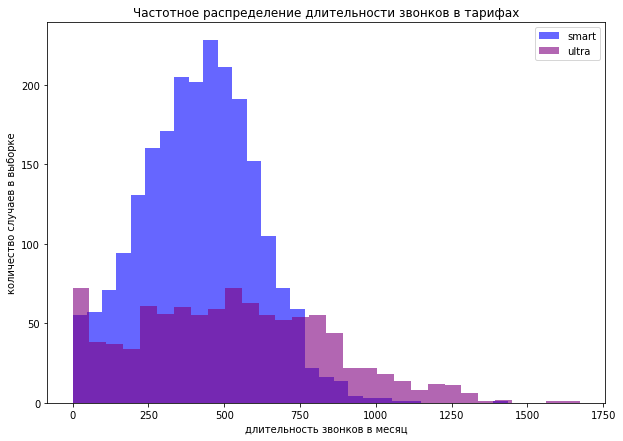

In [32]:
df.query("tariff == 'smart'")['calls'].hist(
    color='blue',
    grid=False,
    alpha=0.6,
    bins=30,
    figsize=(10,7))

df.query("tariff == 'ultra'")['calls'].hist(
    color='purple',
    grid=False,
    alpha=0.6,
    bins=30,
    figsize=(10,7))

plt.legend(['smart','ultra'])
plt.title('Частотное распределение длительности звонков в тарифах')
plt.xlabel('длительность звонков в месяц')
plt.ylabel('количество случаев в выборке')
plt.show()

Действительно среди пользователей тарифа ultra относительная доля тех, кто вовсе не звонит, высока. Причём распределение скорее равномерное, чем нормальное. Длительность звонков пользователей тарифа smart распределена нормально. Примечательно, что даже самые "разговорчивые" пользователи тарифа ultra не тратят максимальный лимит минут по тарифу за месяц - 3000. То есть возможность тратить минуты сколько угодно повышает потребление звонков в среднем на четверть, а не в 6 раз, как прописано в описании тарифа.

### Сколько сообщений требуется пользователям каждого тарифа в месяц?

Посмотрим на описательные статистики переменной числа сообщений:

In [33]:
df.groupby('tariff')['sms'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2229.0,33.384029,28.227876,0.0,10.0,28.0,51.0,143.0
ultra,985.0,49.363452,47.804457,0.0,6.0,38.0,79.0,224.0


Здесь те же тенденции. Пользователи тарифа ultra тратят существенно больше смс в месяц, хотя это число также далеко от тарифного лимита в 1000 сообщений в месяц.

In [34]:
print("Дисперсия количества сообщений тарифа 'ultra'",
      np.var(df.query("tariff == 'ultra'")['sms'], ddof=1))

print("Дисперсия количества сообщений тарифа 'smart'",
      np.var(df.query("tariff == 'smart'")['sms'], ddof=1))

Дисперсия количества сообщений тарифа 'ultra' 2285.2661425446736
Дисперсия количества сообщений тарифа 'smart' 796.8129584480083


Стандартное отклонение различается почти в 2 раза, а дисперсия - почти в 3. Посмотрим на распределение переменной визуально.

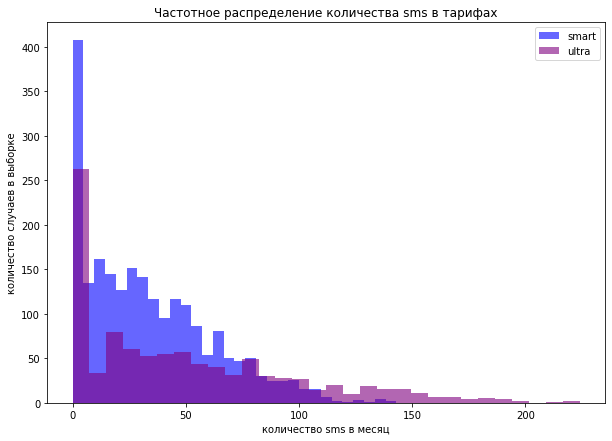

In [35]:
df.query("tariff == 'smart'")['sms'].hist(
    color='blue',
    grid=False,
    alpha=0.6,
    bins=30,
    figsize=(10,7))

df.query("tariff == 'ultra'")['sms'].hist(
    color='purple',
    grid=False,
    alpha=0.6,
    bins=30,
    figsize=(10,7))

plt.legend(['smart','ultra'])
plt.title('Частотное распределение количества sms в тарифах')
plt.xlabel('количество sms в месяц')
plt.ylabel('количество случаев в выборке')
plt.show()

Существенное количество потребителей не пользуется sms вовсе. Это можно объяснить распространением мессенджеров и социальных сетей. Относительно различий по тарифам здесь так же, как и со звонками, частота отправки sms пользователями тарифа ultra распределена скорее равномерно, чем нормально, на отрезке от 50 до 150 смс в месяц.

Тарифный лимит здесь - 1000 смс в месяц, никто из выбранных пользователей не доходит до этой цифры.

### Какой объем трафика требуется пользователям каждого тарифа в месяц?

Посмотрим на описательные статистики переменной объема месячного трафика:

In [36]:
df.groupby('tariff')['gb'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2229.0,16.328847,5.747061,0.0,13.0,17.0,20.0,38.0
ultra,985.0,19.494416,9.853511,0.0,12.0,19.0,27.0,49.0


Здесь у пользователей тарифа ultra тоже значения выше, однако разница не такая драматичная. С учётом большего стандартного отклонения и, как можно предположить, дисперсии, разницу вряд ли можно назвать существенной.

In [37]:
print("Дисперсия количества сообщений тарифа 'ultra'",
      np.var(df.query("tariff == 'ultra'")['gb'], ddof=1))

print("Дисперсия количества сообщений тарифа 'smart'",
      np.var(df.query("tariff == 'smart'")['gb'], ddof=1))

Дисперсия количества сообщений тарифа 'ultra' 97.09168626965459
Дисперсия количества сообщений тарифа 'smart' 33.02870517811161


Предположение о большей дисперсии оказалось верным. Посмотрим на распределение переменной визуально.

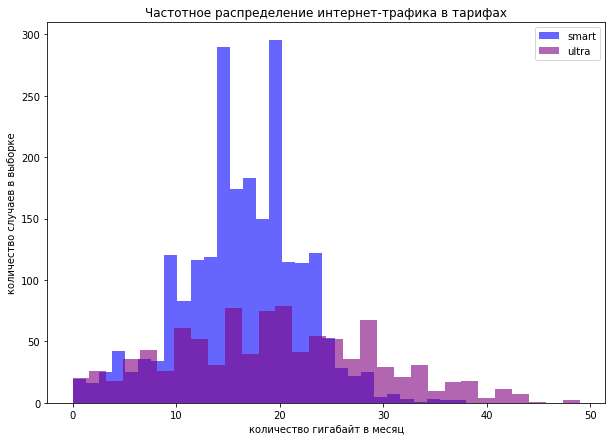

In [38]:
df.query("tariff == 'smart'")['gb'].hist(
    color='blue',
    grid=False,
    alpha=0.6,
    bins=30,
    figsize=(10,7))

df.query("tariff == 'ultra'")['gb'].hist(
    color='purple',
    grid=False,
    alpha=0.6,
    bins=30,
    figsize=(10,7))

plt.legend(['smart','ultra'])
plt.title('Частотное распределение интернет-трафика в тарифах')
plt.xlabel('количество гигабайт в месяц')
plt.ylabel('количество случаев в выборке')
plt.show()

Можно предположить, что оператор в основном зарабатывает на тратах пользователей на интернет, т.к. объем пользования очень приближен к тарифным лимитам, и существенная часть пользователей за них выходит. На гистограмме для тарифа smart отчетливо виден пик в районе 15 Гб, это тарифный лимит, однако даже медиана превышает этот порог, т.е. больше половины пользователей данного тарифа доплачивают за интернет ежемесячно. Примерно каждому пятому пользователю тарифа ultra также не хватает отведённых в месяц 30 Гб. Также отметим, что лимиты звонков и смс на тарифе ultra в десятки раз превосходили лимиты тарифа smart, а для интернета эта разница всего в 2 раза.

### Вывод

- Существенная часть пользователей тарифа smart не укладывается в тарифные лимиты и ежемесячно доплачивает за звонки, sms и гигабайты интернета.
- Наиболее востребованной относительно установленных лимитов является услуга доступа в интернет. Наименее востребованной - sms.
- Во всех случаях пользователи тарифа ultra расходуют в среднем больше sms, звонков и интернета, однако с учётом постоянных доплат за перересход пользователями тарифа smart можно предположить, что именно они приносят оператору больше денег.

## Проверка отдельных гипотез

Для завершения проекта нам нужно проверить, действительно ли оператор зарабатыват по-разному на каждом тарифе и действительно ли средняя выручка в Москве отличается. Для этого воспользуемся Т-тестом для независимых генеральных совокупностей, т.к. мы имеем дело с разными пользователями, которые звонили, писали смс и выходили в интернет одновременно.

### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Нулевая гипотеза: средняя выручка в месяц у пользователей тарифов ultra и smart равна.

Критерий оценки связи: если полученное значение p-value будет меньше принятого уровня значимости (0,05), то мы сможем отвергнуть нулевую гипотезу и сказать, что значимые различия среди пользователей разных тарифов есть. В противном случае мы не сможем утверждать наверняка, равна ли выручка или есть значимые различия, т.к. полученные в выборке значения могут быть случайны.

Альтернативная гипотеза будет таковой: средняя выручка от пользователей тарифов smart и ultra не равна.

In [39]:
alpha = 0.05
print(st.ttest_ind(df.query("tariff == 'ultra'")['bill'], df.query("tariff == 'smart'")['bill']).pvalue)
pd.pivot_table(df, index=['tariff'], values='bill', aggfunc={'mean', 'sum'})

1.4229814360764067e-160


,mean,sum
tariff,,
smart,1289.973531,2875351.0
ultra,2070.152284,2039100.0


Полученное значение говорит о том, что мы с уверенностью 95% можем отвергнуть нулевую гипотезу в пользу альтернативной. Рассчитанные средние значения и суммы указывают на то, что пользователи тарифа ultra в среднем приносят больше за счёт более высокой абонентской платы, однако их немного и суммарный заработок оператора на пользователях двух тарифов сравним, даже на пользователях тарифа smart за счёт их превосходящей численности удаётся заработать немного больше.

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Нулевая гипотеза: средняя выручка в месяц у пользователей из Москвы и регионов равна.

Критерий оценки связи: если полученное значение p-value будет меньше принятого уровня значимости (0,05), то мы сможем отвергнуть нулевую гипотезу и сказать, что значимые различия москвичей от жителей других регионов есть. В противном случае мы не сможем утверждать наверняка, равна ли выручка или есть значимые различия, т.к. полученные в выборке значения могут быть случайны.

Альтернативная гипотеза будет заключаться в неравенстве средней выручки в месяц от пользователей из Москвы и из регионов.

In [40]:
alpha = 0.05
print(st.ttest_ind(df.query("city_grouped == 1")['bill'], df.query("city_grouped == 0")['bill']).pvalue)
pd.pivot_table(df, index=['city_grouped'], values='bill', aggfunc={'mean', 'sum'})

0.5440152911670224


,mean,sum
city_grouped,,
0,1524.936227,3969409.0
1,1546.713584,945042.0


Полученные значения не позволяют нам отвергнуть нулевую гипотезу в пользу альтернативной. Мы не можем говорить о значимости различий дисперсии средних трат на сотовую связь у москвичей и жителей регионов. Кроме того, даже средние траты различаются несущественно. Однако за счёт большего количества пользователей вне Москвы суммарный заработок на них оказывается выше.

### Вывод

1. Если вы думаете, к какому тарифу подлючиться у оператора Мегалайн, то с точки зрения статистики вероятнее, что вам будет выгоден тариф smart. Если же вы представитель оператора и думаете, какой тариф продвигать в первую очередь, то вам будет полезно иметь информацию о том, что выручка с пользователей тарифа ultra выше, порядка 2070 рублей в месяц, когда пользователи тарифа smart приносят по 1290 рублей. Однако с учётом количества пользователей заработок оба тарифа приносят сравнимый.


2. Пользователи из Москвы тратят на сотовую связь не больше, чем жители регионов. Поэтому отбирать регионы для продвижения следуюет по другим критериям.

## Общий вывод

Мы проанализировали предоставленные данные. Сформировали агрегированную таблицу и на ней проверяли выдвинутые гипотезы. В ходе анализа мы обнаружили несколько важных закономерностей:
1. Пользователи тарифа smart очень часто переплачивают за отдельные услуги, им не хватает тарифного лимита в месяц. Абонентская плата на данном тарифе составляет 500 рублей, а в среднем в месяц пользователь данного тарифа тратит в 2,5 раза больше - 1290 рублей.
2. Однако переходить на тариф ultra не каждому пользователю будет выгодно, т.к. абонентская плата там существенно выще - 1950 рублей. Эти пользователи редко не укладываются в тарифные лимиты и средняя плата в месяц очень близка к абонентской - 2070 рублей.
3. Основная причина ежемесячных переплат - пользование услугами интернет. Установленных лимитов не хватает очень существенной части потребителей.
4. Пользователи тарифа smart в среднем ежемесячно платят значимо меньше пользователей тарифа ultra, однако за счёт их количества пользователи обоих тарифов приносят оператору сравнимые деньги.
5. Значимых отличий в ежемесячных тратах на сотовую связь между москвичами и жителями других регионов не выявлено.

Рекомендации:
1. Интернет является основным драйвером роста абонентской платы. Возможно, стоит предложить пользователям тарифы, где в абонентскую плату будет входить только интернет-трафик.
2. Оба тарифа приносят примерно одинаковый оборот (ultra - за счёт абонентской платы, smart - за счёт доплат и общего количества пользоватлей). Однако, если привлечение пользователей в тариф ultra обходится существенно дороже, чем в smart, стоит сконцентрировать усилия на тарифе smart.
3. Москва не является приоритетным регионом для развития данного оператора, т.к. москвичи тратят на сотовую связь примерно столько же, сколько жители регионов. Для отбора регионов стоит сформировать репрезентативную выборку по регионам и проанализировать прочие факторы.